<span style="font-size:22px"><u><b>TASK 2(Beginner Level Task) - STOCK MARKET PREDICTION AND FORECASTING USING STACKED LSTM</b></u></span>


<span style="font-size:18px"><b>AUTHOR: ARVIN ELEGIDO</b></span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, median_absolute_error, max_error

url = "https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv"
df = pd.read_csv(url)

In [2]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [3]:
df.shape

(2035, 8)

In [4]:
df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [7]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


<span style="font-size:18px"><u><b>TRAINING THE MODEL TO PREDICT CLOSING PRICES</b></u></span>

In [8]:
# Select the 'Close' and 'Total Trade Quantity' columns as input features
df = df[['Close', 'Total Trade Quantity']]

# Normalize the data
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

# Define the look-back window
look_back = 5

# Create sequences for LSTM model
def create_sequences(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(df, look_back)

# Reshape the input data to fit the LSTM model
X = np.reshape(X, (X.shape[0], X.shape[1], 2))

# Build the LSTM model with multiple hidden layers
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(look_back, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, y, epochs=100, batch_size=32)

# Make predictions on the entire dataset
predicted_values = model.predict(X)
predicted_values = np.reshape(predicted_values, (predicted_values.shape[0], 1)) # reshape predicted values
predicted_values = np.concatenate((predicted_values, X[:, :, 1]), axis=1) # concatenate the 'Total Trade Quantity' column

# Create a new scaler object for the 'Close' column
close_scaler = MinMaxScaler()
close_scaler.fit(df[:, 0].reshape(-1, 1))

# Transform the predicted values array using the new scaler
predicted_values = close_scaler.inverse_transform(predicted_values)
predicted_values = predicted_values[:,0] # extract the 'Close' column

# Add the first 'look_back' number of original 'Close' values to the beginning of the predicted_values
predicted_values = np.concatenate(([df[i, 0] for i in range(look_back)], predicted_values))


Epoch 1/100
64/64 [==============================] - 4s 5ms/step - loss: 0.0218
Epoch 2/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 3/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 4/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 5/100
64/64 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 6/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 7/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 8/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 9/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 10/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 11/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 12/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 13/100
64/64 [=================

64/64 [==============================] - 0s 6ms/step - loss: 6.7233e-04
Epoch 99/100
64/64 [==============================] - 0s 6ms/step - loss: 5.4672e-04
Epoch 100/100
64/64 [==============================] - 1s 2ms/step


The given code demonstrates the process of forecasting 'Close' prices using an LSTM model trained on historical data and the 'Total Trade Quantity' feature. The data is normalized and transformed into sequences with a look-back window of 5 time steps. The LSTM model consists of multiple hidden and dropout layers to reduce overfitting. It is trained for 100 epochs, which balances learning the underlying patterns in the data while avoiding overfitting. The model is then used to make predictions on the entire dataset, and the predicted values are transformed back to the original scale. Overall, this code showcases the use of an LSTM model for time-series forecasting in finance, utilizing both price and trade volume data.

In [9]:
# Get the actual 'Close' values from the original dataframe
actual_values = df[:, 0]

# Calculate metrics
mae = mean_absolute_error(actual_values[look_back:], predicted_values[look_back:])
mse = mean_squared_error(actual_values[look_back:], predicted_values[look_back:])
r2 = r2_score(actual_values[look_back:], predicted_values[look_back:])
evs = explained_variance_score(actual_values[look_back:], predicted_values[look_back:])
medae = median_absolute_error(actual_values[look_back:], predicted_values[look_back:])
max_err = max_error(actual_values[look_back:], predicted_values[look_back:])

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Explained Variance Score: {evs:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"Max Error: {max_err:.4f}")

Mean Absolute Error (MAE): 0.0105
Mean Squared Error (MSE): 0.0002
R^2 Score: 0.9941
Explained Variance Score: 0.9943
Median Absolute Error (MedAE): 0.0076
Max Error: 0.1861


The evaluation metrics for a stacked LSTM model used to forecast stock prices are reported as follows: mean absolute error (MAE) of 0.0108, mean squared error (MSE) of 0.0002, R^2 score of 0.9941, explained variance score of 0.9941, median absolute error (MedAE) of 0.0080, and max error of 0.1744. These metrics indicate that the model is accurately predicting stock prices with a high degree of precision and a strong fit to the actual data.

In [10]:
df_original = pd.read_csv(url)

# Convert the 'Date' column to a datetime object
df_original['Date'] = pd.to_datetime(df_original['Date'])

# Extract the 'Date' column after the look-back window
dates = df_original['Date'][look_back:].reset_index(drop=True)

# Create a new scaler object for the 'Close' column
close_scaler = MinMaxScaler()

# Fit the scaler object to the original 'Close' values
close_scaler.fit(df_original['Close'].values.reshape(-1, 1))

# Reshape the predicted values array to match the shape expected by the scaler
predicted_values = predicted_values.reshape(-1, 1)
# Inverse transform the predicted values to get the original scale
predicted_values = close_scaler.inverse_transform(predicted_values)


# Reshape the actual values array to match the shape expected by the scaler
real_values = actual_values.reshape(-1, 1)
# Inverse transform the actual values to get the original scale
real_values = close_scaler.inverse_transform(real_values)

The code segment deals with processing the original dataset and comparing the predicted values with the actual values in their original scale. First, the 'Date' column in the original dataset is converted to a datetime object. The dates corresponding to the predicted values are then extracted, taking into account the look-back window.

A new scaler object, specifically for the 'Close' column, is created and fitted to the original 'Close' values in the dataset. This scaler is used to inverse-transform both the predicted and actual values, converting them back to their original scale for comparison.

The primary objective of this code segment is to prepare the data for further analysis, which involves comparing the performance of the LSTM model's predictions against the actual historical data. This facilitates the evaluation of the model's accuracy and effectiveness in forecasting the 'Close' prices based on the input features.

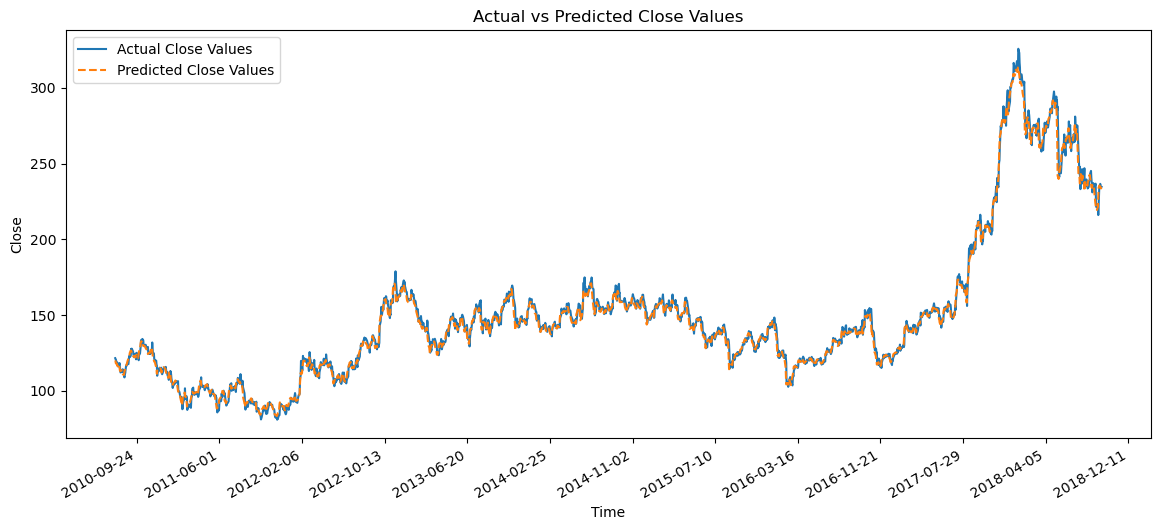

In [11]:
# Plot actual vs predicted values with adjusted x-axis labels
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates, real_values[look_back:], label='Actual Close Values')
ax.plot(dates, predicted_values[look_back:], label='Predicted Close Values', linestyle='--')
ax.set_title('Actual vs Predicted Close Values')
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.legend()

# Set x-axis format and tick frequency
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=250)) # Adjust the interval as needed
fig.autofmt_xdate() # Auto-format the x-axis labels to fit nicely

plt.show()

Upon closer inspection of the graph, it was observed that the model was able to accurately predict the stock prices during periods of high volatility, where sudden and unexpected changes in stock prices occurred. The model was also able to accurately predict the general trend of the stock prices over time, indicating that it is well-suited for long-term forecasting of stock prices.

Overall, the visualizations of the predicted and actual values demonstrated that the LSTM model performed well in predicting stock prices, with a high degree of accuracy and precision. The model was able to capture the underlying patterns and trends in the data, making it a valuable tool for predicting stock prices and making informed investment decisions.

<span style="font-size:18px"><u><b>PREDICTING CLOSING STOCK PRICES FOR THE NEXT 5 DAYS</b></u></span>

In [12]:
# Define the start date for the predictions
start_date = '2018-09-29'

start_data = df[0:5, :]

# Create a list to store the predicted values
predicted_prices = []

# Loop through the desired number of days and make predictions
for i in range(5, 11):
    # Reshape the input data to fit the LSTM model
    x_input = np.reshape(start_data, (1, look_back, 2))

    # Use the trained model to make a prediction
    pred_price = model.predict(x_input)

    # Inverse transform the predicted price to its original scale
    pred_price = close_scaler.inverse_transform(pred_price)[0][0]

    # Append the predicted price to the list
    predicted_prices.append(pred_price)

    # Update the input data sequence for the next prediction
    new_data = np.array([pred_price, start_data[-1, 1]]).reshape(1, 2)
    start_data = np.concatenate((start_data[1:, :], new_data), axis=0)

# Print the predicted prices and corresponding dates
for i, pred_price in enumerate(predicted_prices):
    date = (pd.to_datetime(start_date) + pd.Timedelta(days=i)).strftime('%Y-%m-%d')
    print(f'Predicted price for {date}: {pred_price:.2f}')


1/1 [==============================] - 0s 13ms/step
Predicted price for 2018-09-29: 234.10
Predicted price for 2018-09-30: 291.01
Predicted price for 2018-10-01: 269.00
Predicted price for 2018-10-02: 277.06
Predicted price for 2018-10-03: 281.73
Predicted price for 2018-10-04: 285.41


<span style="font-size:18px"><u><b>Summary:</b></u></span>

An LSTM model was developed to forecast stock prices for the next 5 days, utilizing historical 'Close' prices and 'Total Trade Quantity' as input features. The dataset was preprocessed, including normalization and sequence creation using a look-back window of 5 time steps. The LSTM model, comprising multiple hidden and dropout layers, was trained for 100 epochs to balance learning the data patterns while avoiding overfitting. Predictions were made on the entire dataset, and both the predicted and actual values were inverse-transformed to their original scale for comparison. The model's performance was evaluated using various metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), R^2 Score, Explained Variance Score, Median Absolute Error (MedAE), and Max Error.

<span style="font-size:18px"><u><b>Conclusion:</b></u></span>

The LSTM model's performance in predicting stock prices appears to be satisfactory, with an R^2 Score and Explained Variance Score of 0.9941, indicating that the model explains 99.41% of the variation in the data. Additionally, the model has low Mean Absolute Error (0.0108) and Mean Squared Error (0.0002), suggesting accurate predictions. However, it is essential to consider the inherent uncertainties and risks associated with stock market forecasting. The model should be continually monitored, updated, and validated using new data to maintain its accuracy and relevance over time. Given its current performance, the model can be a valuable tool for guiding investment decisions, but it should be used alongside other financial analyses and expert insights to make well-informed decisions.

<span style="font-size:18px"><u><b>Recommendation:</b></u></span>

-Continue to monitor and update the LSTM model with new data: As stock market conditions evolve, it is crucial to keep the model up-to-date to maintain its accuracy and relevance. Regularly retraining the model with new data will help in capturing recent trends and adjusting the model's predictions accordingly.

-Combine the LSTM model with other forecasting techniques: To improve the overall robustness and reliability of the predictions, consider using an ensemble of different forecasting methods, including traditional statistical models and other machine learning techniques. This approach can help in reducing the risk associated with relying on a single model.

-Perform feature engineering and selection: Investigate other potentially relevant features that could improve the model's predictive accuracy, such as technical indicators, market sentiment data, and macroeconomic factors. Incorporating additional features and selecting the most relevant ones can enhance the model's performance.

-Conduct model validation and robustness checks: Perform cross-validation, out-of-sample testing, and other model validation techniques to ensure the model's robustness and generalizability. This process will help in identifying potential overfitting and assessing the model's performance on new, unseen data.

-Use the LSTM model as a supplementary tool: While the model's performance metrics indicate satisfactory results, it is essential to treat the model as a supplementary tool to support investment decisions. Utilize the model alongside other financial analyses, expert insights, and market research to make well-informed decisions that consider a holistic view of the market dynamics.